**JARRAR ACHRAF**

This project consists of optimizing a portfolio based on stocks of Apple, Microsoft, Google, Amazon and Meta stocks.

We will define the objective functions to maximize or minimize.

We will then verify the result by using Efficient Frontier.

We will describe each of the optimal portfolios using many optimzation metrics and general information like skewness and kurtosis.

We will compare and talk about the portfolios at the end.

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from rich.console import Console
from rich.table import Table
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.stats import skew, kurtosis
from scipy.stats.mstats import gmean


In [2]:
# Choose Assets to Include in the Portfolio and Select Sample Period
symbols = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META']
start_date = '2019-01-01'
end_date = '2024-01-01'

data = yf.download(symbols, start=start_date, end=end_date)['Adj Close']

[*********************100%***********************]  5 of 5 completed


In [3]:
# Calculate Returns
returns = data.pct_change().dropna()

### Sharpe Ratio :
The Sharpe Ratio is defined as:

$$
\text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}
$$

where:

- $R_p$ is the expected return of the portfolio,
- $R_f$ is the risk-free rate,
- $\sigma_p$ is the standard deviation of the portfolio returns (a measure of risk).

The Sharpe Ratio evaluates the return of an investment relative to its risk. The higher the Sharpe Ratio, the better the investment's return compared to its risk.

A higher ratio means that the investment provides more return per unit of risk, which is generally more desirable. That's why we want to maximize it. So we will minimize the negative sharpe ratio.

The formula of Sharpe Ratio in our case is :

The Sharpe Ratio is defined as:

$$
\text{Sharpe Ratio} = \frac{\mathbf{w}^T \mathbf{R} - R_f}{\sqrt{\mathbf{w}^T \mathbf{\Sigma} \mathbf{w}}}
$$

where:

- $\mathbf{R}$ is the vector of expected returns for each asset.
- $\mathbf{\Sigma}$ is the covariance matrix of asset returns.
- $\mathbf{w}$ is the vector of portfolio weights.
- $R_f$ is the risk-free rate.
- The term $\mathbf{w}^T \mathbf{\Sigma} \mathbf{w}$ represents the portfolio variance, and $\sqrt{\mathbf{w}^T \mathbf{\Sigma} \mathbf{w}}$ is the portfolio standard deviation (risk).

  **For simplicity we will take Risk-free rate as 0**

In [4]:
# Define Objective Function for Sharpe Ratio Optimization
def objective_sharpe(weights):

    wtR = np.dot(weights, returns.mean())

    Rf = 0

    std_dev = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

    sharpe_ratio = (wtR-Rf)/std_dev

    return -sharpe_ratio


### Value at Risk :

Value at Risk (VaR) is a statistical measure used in finance to quantify the risk of loss on a portfolio. It estimates the maximum loss that a portfolio could experience over a specified time period, given a certain confidence level. In other words, VaR tells us how much we might lose (at maximum), but with a specified level of certainty.  In the case of a normally distributed returns of portfolio the formula is as follows (Of course thanks to central limit theorem we can use this formula) :

$$
\text{VaR}_\alpha = \mu - \sigma \cdot \Phi^{-1}(\alpha)
$$

where:

- $\mu$ is the mean (expected) return of the portfolio,
- $\sigma$ is the standard deviation of the portfolio returns,
- $\Phi^{-1}(\alpha)$ is the inverse cumulative distribution function (quantile function) at the confidence level $\alpha$.


In [5]:
# Define Objective Function for Value at Risk Optimization
def objective_var(weights):
    portfolio_returns = np.dot(returns, weights)
    portfolio_mean = portfolio_returns.mean()
    portfolio_std = portfolio_returns.std()
    conf_level = 0.05  # Confidence level for vaR at 95%
    var = portfolio_mean - portfolio_std * norm.ppf(conf_level)
    return var


### The Sortino Ratio
 It is a risk-adjusted performance metric used to evaluate the return of an investment relative to the risk of negative returns. It's similar to the Sharpe Ratio but specifically focuses on downside risk. Unlike the Sharpe Ratio, which considers all variability in returns (both positive and negative), the Sortino Ratio only considers downside risk. This is because investors are generally more concerned about negative deviations from their expected return than they are about positive deviations.

 $$
\text{Sortino Ratio} = \frac{R_p - R_f}{\sigma_d}
$$

where:

- $R_p$ is the portfolio's return (or the return of the investment).
- $R_f$ is the risk-free rate.
- $\sigma_d$ is the standard deviation of the negative returns, known as downside deviation.

We will consider the risk-free rate as 0 for simplicity.


In [6]:
def objective_sortino(weights):
    portfolio_returns = np.dot(returns, weights)
    downside_returns = portfolio_returns[portfolio_returns < 0]
    downside_std = downside_returns.std()
    sortino_ratio = portfolio_returns.mean() / downside_std
    return -sortino_ratio  # Maximize Sortino Ratio

### Variance
It is used as a measure of risk. A higher variance indicates a higher spread of returns, implying greater uncertainty or risk. By minimizing variance, we are essentially seeking to create a portfolio with lower risk.

The formula for the variance of a portfolio's returns is:

$$
\sigma_p^2 = \mathbf{w}^T \mathbf{\Sigma} \mathbf{w}
$$

where:

- $\sigma_p^2$ is the variance of the portfolio's returns.
- $\mathbf{w}$ is the vector of portfolio weights.
- $\mathbf{\Sigma}$ is the covariance matrix of the asset returns.

We multiply the variance by 252, by assuming that there are 252 trading days in a year, to get annualized variance

In [7]:
# Define Objective Function for Variance Minimization
def objective_variance(weights):
    return np.dot(weights.T, np.dot(returns.cov() * 252, weights))

### Get optimized Portfolio for each objective function

We will use SLSQP because it is adapted for minimizing non-linear objective functions wiht equality constraints and bounds.

In [8]:
# Constraints : Sum of weights equals 1
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
# Bounds for Weights : between 0 and 1
bounds = tuple((0, 1) for x in range(len(symbols)))

# We initialize the weights by considering them equal

init = np.array(len(symbols) * [1. / len(symbols),])

In [9]:
# Optimize All Criteria
opt_results_var = minimize(objective_var, init, method='SLSQP', bounds=bounds, constraints=cons)
opt_results_sortino = minimize(objective_sortino, init, method='SLSQP', bounds=bounds, constraints=cons)
opt_results_variance = minimize(objective_variance, init, method='SLSQP', bounds=bounds, constraints=cons)
opt_results_sharpe = minimize(objective_sharpe, init, method='SLSQP', bounds=bounds, constraints=cons)

# Optimal Weights for Each Criterion
optimal_weights_var = opt_results_var.x
optimal_weights_sortino = opt_results_sortino.x
optimal_weights_variance = opt_results_variance.x
optimal_weights_sharpe = opt_results_sharpe.x


### Efficient Frontier :
It is a concept in portfolio theory that helps investors understand the trade-off between risk and return for different investment portfolios.

The goal is to find the best possible portfolio that provides the highest return for a given level of risk, or the lowest risk for a given level of return.

For instance the portfolios that lie below the Efficient Frontier are not optimal because they offer lower returns for the same risk or higher risk for the same return.

For this we will generate a big number of portfolios with random weights, calculate the volatility and returns and save if for plotting.

We will then place our optimal portfolios in the graph and see where they lie.

We will use Sharpe Ratio.

In [10]:
sharpe_ratio = []
all_weights = []
portfolio_returns = []
portfolio_volatility = []
num_assets = len(symbols)
num_portfolios = 100000

In [11]:
for port in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns_portfolio = np.dot(weights, returns.mean()) * 252
    volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sr = returns_portfolio / volatility
    sharpe_ratio.append(sr)
    portfolio_returns.append(returns_portfolio)
    portfolio_volatility.append(volatility)
    all_weights.append(weights)

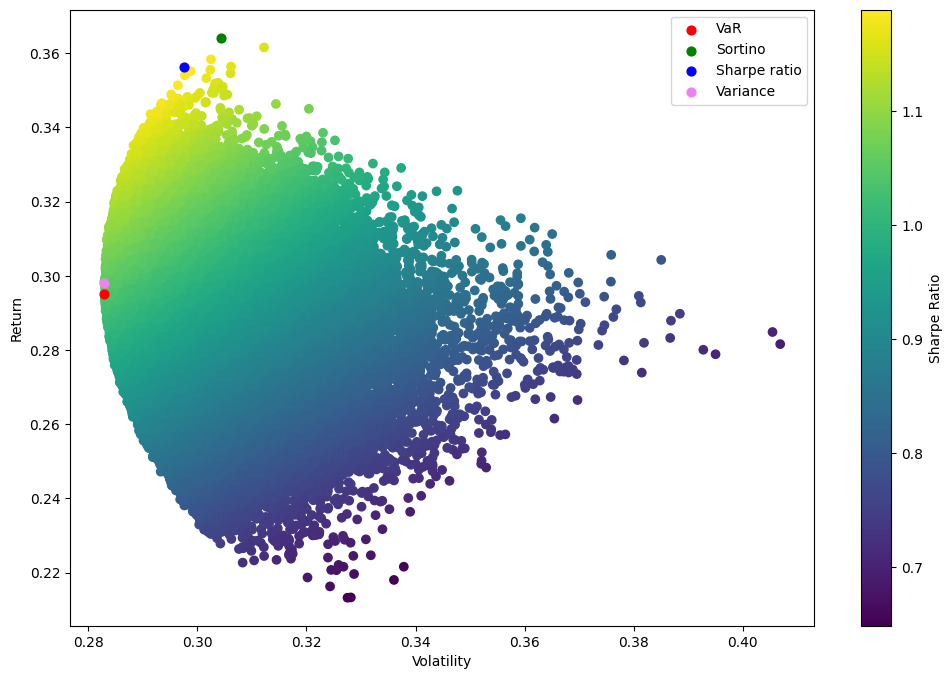

In [12]:
plt.figure(figsize=(12, 8))
plt.scatter(portfolio_volatility, portfolio_returns, c=sharpe_ratio, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

def scatter_optimal_portfolios(weights,color,label):
  opt_returns = np.dot(weights, returns.mean()) * 252
  opt_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
  plt.scatter(opt_volatility, opt_returns, color=color, s=40, label=label)

scatter_optimal_portfolios(optimal_weights_var,'red','VaR')
scatter_optimal_portfolios(optimal_weights_sortino,'green','Sortino')
scatter_optimal_portfolios(optimal_weights_sharpe,'blue','Sharpe ratio')
scatter_optimal_portfolios(optimal_weights_variance,'violet','Variance')
plt.legend(loc='upper right')
plt.show()

We clearly see the our portfolios lie in the frontier which means that for a their expected return they have the lowest risk ( or that for their risk they give the highest expected return)

Now we will calculate for each portfolio its charectaristics to describe it.

Let's start by defining the **Maximum Drawdown** :

It is a risk metric used to assess the largest peak-to-trough decline in the value of an investment or portfolio over a specified period. It measures the worst-case scenario for a loss in the value of an investment, helping investors understand the potential for significant declines.

So we will calculate the cumulative growth of our portfolio over time ( which is why we need to account for the initial capital).

We use an expanding window so that, each day, the corresponding value in the peak list will be equal to max(previous_maximum,the_cumulative_growth_up_to_the_current_day)

In [13]:
def maximum_drawdown(daily_returns):
    cumulative_growth = (1 + daily_returns).cumprod() # We add the 1 to account for initial capital
    peak = cumulative_growth.expanding(min_periods=1).max()
    drawdown = (cumulative_growth-peak/peak)
    return drawdown.min()


## Annualized returns mean :

We use geometric mean because it is adapted to multiplicative effects.

This gives the mean of the daily returns. We need to annualize it for consistency.

then substract 1 to get the annualized average return.

In [14]:
def annualized_mean_return(daily_returns):

  return gmean(daily_returns + 1)**252 - 1

### Annualized standard deviation :

It represents how much the returns of the investment are expected to deviate from the average annual return.

In [15]:
def annualized_standard_deviation(daily_returns):

  return daily_returns.std() * np.sqrt(252)

### Skewness :

It is a statistical measure that describes the asymmetry of a probability distribution or dataset around its mean. It provides insight into the shape of the distribution, specifically whether the data is skewed to the left or right.

Skewness helps to gauge whether the portfolio's returns are symmetrically distributed or if there are tendencies towards extreme positive or negative returns.

In [16]:
def skewness_calculate(daily_returns):

  return skew(daily_returns)


### Kurtosis :
It is a statistical measure that describes the shape of the distribution of data, specifically the tails and the peak of the distribution.

 * Higher kurtosis indicates the potential for extreme returns (both high and low), which might suggest higher risk in the portfolio due to potential outliers.
 * Lower kurtosis suggests fewer extreme returns, indicating a more stable distribution with fewer outliers.

In [17]:
def kurtosis_calculate(daily_returns):

  return kurtosis(daily_returns)

In [18]:
def portfolio_information(weights):

    portfolio_daily_returns = returns.dot(weights)

    # General Descriptive Information

    mean_return_annualized = annualized_mean_return(portfolio_daily_returns)
    std_dev_annualized = annualized_standard_deviation(portfolio_daily_returns)
    skewness = skewness_calculate(portfolio_daily_returns) # Time invariant
    kurt = kurtosis_calculate(portfolio_daily_returns) # Time invariant
    max_dd = maximum_drawdown(portfolio_daily_returns)
    count = len(portfolio_daily_returns)

    # Optimization Metrics
    sharpe_ratio = (mean_return_annualized ) / std_dev_annualized
    conf_level = 0.05
    var = mean_return_annualized - std_dev_annualized * norm.ppf(conf_level)
    downside_returns = portfolio_daily_returns[portfolio_daily_returns < 0]
    downside_std_dev = downside_returns.std() * np.sqrt(252)
    sortino_ratio = mean_return_annualized / downside_std_dev
    variance = std_dev_annualized ** 2

    return mean_return_annualized, std_dev_annualized, skewness, kurt, max_dd, count, sharpe_ratio, var, sortino_ratio, variance

### Describe all of our portfolios :

In [19]:
_var = portfolio_information(optimal_weights_var)
_sortino = portfolio_information(optimal_weights_sortino)
_variance = portfolio_information(optimal_weights_variance)
_sharpe = portfolio_information(optimal_weights_sharpe)

In [20]:
# Initialize Rich console for beautiful printing
console = Console()
Information = [
    'Annualized Return', 'Annualized Volatility', 'Skewness', 'Kurtosis',
    'Max Drawdown', 'Data Count', 'Sharpe Ratio', 'VaR', 'Sortino Ratio', 'Variance'
]
# Dictionary Associating Optimization Methods with Weights and Information
portfolio_data = {
    'VaR': {
        'weights': optimal_weights_var,
        'Information': _var
    },
    'Sortino': {
        'weights': optimal_weights_sortino,
        'Information': _sortino
    },
    'Variance': {
        'weights': optimal_weights_variance,
        'Information': _variance
    },
    'Sharpe': {
        'weights': optimal_weights_sharpe,
        'Information': _sharpe
    },
}

In [21]:
# Iterate over each optimization method and display results
for method, data in portfolio_data.items():
    print(f"\nOptimal Portfolio Weights and Information for {method}:\n")

    # Display the optimal weights
    print(f"Optimal Portfolio Weights for {method}:")
    for symbol, weight in zip(symbols, data['weights']):
        weight_str = f"{weight*100:.2f}%" if weight >= 1e-4 else "practically 0%"
        print(f"  {symbol}: {weight_str}")

    # Display the descriptive Information
    print(f"\nDescriptive Information for the Optimal Portfolio under {method}:")
    for name, stat in zip(Information, data['Information']):
        stat_value = f"{stat*100:.2f}%" if name != 'Data Count' else f"{stat:.2f}"
        print(f"  {name}: {stat_value}")

    print("-" * 50)  # Separator line



Optimal Portfolio Weights and Information for VaR:

Optimal Portfolio Weights for VaR:
  AAPL: 24.97%
  MSFT: 15.73%
  GOOG: 28.97%
  AMZN: practically 0%
  META: 30.33%

Descriptive Information for the Optimal Portfolio under VaR:
  Annualized Return: 29.02%
  Annualized Volatility: 28.29%
  Skewness: -16.30%
  Kurtosis: 461.83%
  Max Drawdown: -4.83%
  Data Count: 1257.00
  Sharpe Ratio: 102.59%
  VaR: 75.56%
  Sortino Ratio: 138.99%
  Variance: 8.00%
--------------------------------------------------

Optimal Portfolio Weights and Information for Sortino:

Optimal Portfolio Weights for Sortino:
  AAPL: 76.03%
  MSFT: practically 0%
  GOOG: practically 0%
  AMZN: practically 0%
  META: 23.97%

Descriptive Information for the Optimal Portfolio under Sortino:
  Annualized Return: 37.39%
  Annualized Volatility: 30.43%
  Skewness: -10.47%
  Kurtosis: 597.51%
  Max Drawdown: -8.46%
  Data Count: 1257.00
  Sharpe Ratio: 122.89%
  VaR: 87.44%
  Sortino Ratio: 167.42%
  Variance: 9.26%
---

Conclusion :

It depends on the type of investor. If he seeks high risk and so higher expected return, He can opt for the last portfolio ( Sharpe ) or for the optimal Portfolio under Sortino.
The skewness is negative for all portfolios which indicates that all of them tend to have tendency to negative returns.
This is coherent to the levels of kurtosis which are superior to 3 which means the portfolio returns are prone to large swings.